
Assignment 4:

Name: Chandrakanth b

UID:118259949

Course: CMSC733

Please submit to ELMS - a PDF containing all outputs (by executing Run all) - 

your ipynb

notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of 

online material). Please

sign your name here: Chandrakanth b

In [1]:
 ## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.8 MB/s 
time: 510 µs (started: 2022-11-26 17:27:13 +00:00)


In [2]:
def show_image(img, scale=1.0):
  plt.figure(figsize=scale* plt.figaspect(1))
  plt.imshow(img)
  plt.gray()
  plt.axis('off')
  plt.show()


time: 987 µs (started: 2022-11-26 17:27:17 +00:00)


time: 1.63 ms (started: 2022-11-24 00:57:50 +00:00)


time: 2.04 s (started: 2022-11-26 02:32:39 +00:00)


**Part 1: SLIC Superpixels (50 Points)**

**1.1 Overview1** 

---


Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential
object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass
object segmentation, depth estimation, human pose estimation, and object localization.
In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative
Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g.,
r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally
sampled regular grid on the image of N pixels. For each cluster, you define for a localized window
2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the
seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should
be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster
center). Once you loop through all the clusters, you can update the cluster center by averaging over
the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum
iterations reached.
Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here:

https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link

**1.2 Data**

**WARNING: **

Colab deletes all files everytime runtime is disconnected. Make sure to
re-download the inputs when it happens.

In [4]:
 # Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"


Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 116MB/s]
Archive:  /content/Part1_SLIC.zip
replace /content/Part1_SLIC/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._groundTruth  
  inflating: /content/Part1_SLIC/sample_data/images/5096.jpg  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/images/._5096.jpg  
  inflating: /content/Part1_SLIC/sample_data/imag

time: 3.61 s (started: 2022-11-26 02:32:42 +00:00)


 **1.3 Helper Functions:
1.3.1 Code (15 pts)**


In [5]:
 # A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):
  def __init__(self, l=0, a=0, b=0, h=0, w=0):
    self.update(l, a, b, h, w)
    self.pixels = []
  def update(self, l, a, b, h, w):
    self.l = l
    self.a = a
    self.b = b
    self.h = h
    self.w = w
# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
  return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)
def display_clusters(img, clusters):
  image = np.copy(img)
  for c in clusters:
    for p in c.pixels:
      image[p[0],p[1]][0] = c.l
      image[p[0],p[1]][1] = c.a
      image[p[0],p[1]][2] = c.b
    image[c.h, c.w][0] = 1
    image[c.h, c.w][1] = 0
    image[c.h, c.w][2] = 0
  rgb_arr = color.lab2rgb(image)
  show_image(rgb_arr,2.0)


time: 3.61 ms (started: 2022-11-26 05:02:20 +00:00)


time: 9.13 ms (started: 2022-11-24 02:09:16 +00:00)




In [6]:
# Functions for Simple Linear Iterative Clustering (SLIC)
def initialize_cluster_centers(S, image, img_h, img_w, clusters):
# To Do: Initialize "clusters" by sampling pixels at an equally sampled␣,→regular grid (distanced by S)
# on the image of N pixels. N = img_h X img_w. Hint: clusters.,→append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
  for i in range(S,img_h,S):
    for j in range(S,img_w,S):
      clusters.append(make_SuperPixel(i,j,image))
  return clusters
def relocate_cluster_center_at_lowgrad(clusters, image):
# To Do:
# for each cluster c, reassign cluster to the pixel having smallest gradient␣,→value.
# Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood␣,→of cluster center.
# Step 2: Similarly, compute gradient for each pixel in 3X3 spatial␣,→neighborhood of cluster c.
# Step 3. Reassign cluster-center to the pixel (x,y) having the lowest␣,→gradient.
# Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
# computing gradient
  yGradL,xGradL=np.gradient(image[:,:,0])
  yGradA,xGradA=np.gradient(image[:,:,1])
  yGradB,xGradB=np.gradient(image[:,:,2])
  grad = np.square(xGradL) + np.square(xGradA)+ np.square(xGradB)+ np.square(yGradL) + np.square(yGradA)+ np.square(yGradB)
# show_image(grad,2)
  windowSize = 7
  border = windowSize//2
  axis=np.linspace(-border,border,7)
  colVal,rowVal=np.meshgrid(axis,axis)
  for c in clusters:
# Grab a 3*3 gradient window around cluster center
    window = grad[c.h-border:c.h+border+1,c.w-border:c.w+border+1]
# print("old center: ",c.h,c.w)
# lowest-gradient index
    windowIndex = np.nonzero(window==np.min(window))
# print("min location is:",windowIndex)
# obtaining new center for cluster
    newH = c.h+int(rowVal[windowIndex][0])
    newW = c.w+int(colVal[windowIndex][0])
# print(" new center: ",newH,newW)
# updating each cluster center
    c.update(image[newH,newW][0],image[newH,newW][1],image[newH,newW][2],newH,newW)
  return clusters
def assign_cluster(clusters, S, image, img_h, img_w,m1,m2):
#### Write your code here ####
# To Do: Compare each pixel to cluster center within 2S pixel distance and␣assign to nearest cluster using the "distance metric"
# (involving both color and spatial dimensions of pixel and cluster,
# Hints:
# 1. use "dis" matrix for comparing distances.
# 2. You can use c.pixels.append((h, w)) to keep track of␣cluster-assignments.
  for c in clusters:
    c.pixels=[]
# for every pixel
  for i in range(img_h):
    for j in range(img_w):
      disMatrix = np.full((len(clusters),1),np.inf)
# go through all clusters
      for c_i,c in enumerate(clusters):
        dE = np.linalg.norm(np.array([c.h-i , c.w-j]))
# if Euclidean distance < 2*S
        if dE < 2*S:
          dLAB = np.linalg.norm(np.array([c.l-image[i,j][0],c.a-image[i,j][1],c.b-image[i,j][2]]))
          dTotal = m1*dLAB + m2*dE
          disMatrix[c_i,0] = dTotal
# print(disMatrix)
# find min-distance cluster, index
        index=np.argmin(disMatrix,axis=0)
# assign pixel to min-distance cluster
        clusters[index[0]].pixels.append([i,j])
  return clusters
def update_clusters(clusters,image):
#### Write your code here ####
# To Do: For each cluster, update the cluster center with mean of the pixels␣assigned (c.pixels)
  for c in clusters:
    try:
      pixelsArray = np.reshape(c.pixels,(len(c.pixels),2))
      meanH,meanW=np.mean(pixelsArray,axis=0)
      meanH=int(meanH)
      meanW=int(meanW)
    except:
      meanH=c.h
      meanW=c.w
    c.update(image[meanH,meanW][0],image[meanH,meanW][1],image[meanH,meanW][2],meanH,meanW)
  return None
def compute_res_error(old_clusters, new_clusters):
#### Write your code here ####
  error = 0.0
# error = Compute L1 distance between previous cluster-centres and new␣cluster centers.
  for i in range(len(old_clusters)):
    ldif=old_clusters[i].l-new_clusters[i].l
    adif = old_clusters[i].a-new_clusters[i].a
    bdif= old_clusters[i].b-new_clusters[i].b
    hdif= old_clusters[i].h-new_clusters[i].h
    wdif = old_clusters[i].w-new_clusters[i].w
    error= error+ np.sum(np.abs(np.array([ldif,adif,bdif,hdif,wdif])))
  return error
def slic_algorithm(S, image, img_h, img_w, clusters,m1,m2):
# Initialize cluster centers on pixel grid in steps S
  clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
# Move centers to position in 3x3 window with smallest gradient.
  relocate_cluster_center_at_lowgrad(clusters, image)
# You can play around with these hyper-params.
  res_err = 123456789.0 # init residual_error with a very large value (choose␣as per your understanding.)
  threshold = 3*len(clusters) # tune this
  i=0
  while(res_err >= threshold and i<6):
    print("iteration:",i)
    assign_cluster(clusters, S, image, img_h, img_w,m1,m2)
    old_clusters = copy.deepcopy(clusters)
    update_clusters(clusters,image)
    res_err = compute_res_error(old_clusters, clusters)
    print("res_err", res_err)
    if res_err<threshold:
      break
    i+=1
  return clusters

time: 8.99 ms (started: 2022-11-26 05:02:22 +00:00)


time: 10.2 ms (started: 2022-11-24 02:09:48 +00:00)

---

time: 1.38 s (started: 2022-11-26 05:02:22 +00:00)


In [7]:
# Main Block:
img_path0 = "/content/Part1_SLIC/BSD_data/images/81095.jpg"
img_path1 = "/content/Part1_SLIC/BSD_data/images/10081.jpg"
img_path2 = "/content/Part1_SLIC/BSD_data/images/79073.jpg"
img_path3 = "/content/Part1_SLIC/BSD_data/images/35049.jpg"
img_path4 = "/content/Part1_SLIC/BSD_data/images/41085.jpg"

def slicPipeline(img_path,K,m1,m2):
# Load image and convert it from an unsigned 8-bit integer to a floating point␣data type.
  imagergb = img_as_float(io.imread(img_path))
# convert RGB to LAB
  image = color.rgb2lab(imagergb)
  img_h = image.shape[0] # Height
  img_w = image.shape[1] # Width
# k: Number of clusters/superpixels.
  k = K
  N = img_h * img_w # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel
# print("average size S:",S)
  clusters = []
# cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel␣h,w. For example, cluster_tag[(h, w)] = c
# dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster␣is initialized as infinity at the beginning.
  finalClusters = slic_algorithm(S, image, img_h, img_w, clusters,m1,m2)
  return finalClusters,image

time: 1.65 ms (started: 2022-11-26 05:02:24 +00:00)


time: 2.82 ms (started: 2022-11-24 02:09:51 +00:00)

---




time: 1.42 s (started: 2022-11-26 02:32:50 +00:00)


**1.3.2 Write-up (35 pts)**

• **a) [5 points]**

 Explain your distance function for measuring the similarity between a pixel
and cluster in the 5D space.
•
 **b) [5 points]**
 
Choose one image, try three different weights on the color and spatial feature
and show the three segmentation results. Describe what you observe.
• 

**c) [5 points]**

Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
• 

**d) [10 points]**

Choose one image and show three superpixel results with different number of
K, e.g., 64, 256, 1024 and run time for each K.
•
 **e) [10 points]**
 
Run your algorithms on the subset (50 images) of Berkeley Segmentation
Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for
the BSD.
**1.3.3 Extra Credit (20 pts)**
• 
**f) [upto 10 points]** Implement and report two types of metrics (1) boundary recall and (2)
under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).

• **g) [upto 10 points]**

Try to improve your result from first part of extra-credit. You may try
different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features(e.g., gradients) or any other ideas you come up with. Report the accuracy on boundaryrecall and under-segmentation error with K = 256. Compare the results with first-partof extra-credit and explain why you get better results.

time: 3.18 s (started: 2022-11-26 02:32:50 +00:00)


** 1.3.3 (f)**
---

In [7]:
import cv2
import numpy as np
from skimage import img_as_ubyte
from google.colab.patches import cv2_imshow
image = cv2.imread("/content/Part1_SLIC/BSD_data/images/10081.jpg")
mask = np.zeros(image.shape[:2], dtype="uint8")
rect = (31, 43, 70, 68)
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
fgModel, iterCount=15, mode=cv2.GC_INIT_WITH_RECT)
values = (
("Definite Background", cv2.GC_BGD),
("Probable Background", cv2.GC_PR_BGD),
("Definite Foreground", cv2.GC_FGD),
("Probable Foreground", cv2.GC_PR_FGD),
)
mask_list = list()
# loop over the possible GrabCut mask values
for (name, value) in values:
  valueMask = (mask == value).astype("uint8") * 255
  mask_list.append(valueMask)
import math
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
  assert np.atleast_3d(foreground_mask).shape[2] == 1
  bound_pix = bound_th if bound_th >= 1 else \
  np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))
# Get the pixel boundaries of both masks
  fg_boundary = seg2bmap(foreground_mask);
  gt_boundary = seg2bmap(gt_mask);
  from skimage.morphology import binary_dilation,disk
  fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
  gt_dil = binary_dilation(gt_boundary,disk(bound_pix))
# Get the intersection
  gt_match = gt_boundary * fg_dil
  fg_match = fg_boundary * gt_dil
# Area of the intersection
  n_fg = np.sum(fg_boundary)
  n_gt = np.sum(gt_boundary)
#% Compute boundary recall
  if n_fg == 0 and n_gt > 0:
    recall = 0 
  elif n_fg > 0 and n_gt == 0:
    recall = 1
  elif n_fg == 0 and n_gt == 0:
    recall = 1
  else:
    recall = np.sum(gt_match)/float(n_gt)
  return recall
def seg2bmap(seg,width=None,height=None):
  seg = seg.astype(np.bool_)
  seg[seg>0] = 1
  assert np.atleast_3d(seg).shape[2] == 1
  width = seg.shape[1] if width is None else width
  height = seg.shape[0] if height is None else height
  h,w = seg.shape[:2]
  ar1 = float(width) / float(height)
  ar2 = float(w) / float(h)
  assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
  'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)
  e = np.zeros_like(seg)
  s = np.zeros_like(seg)
  se = np.zeros_like(seg)
  e[:,:-1] = seg[:,1:]
  s[:-1,:] = seg[1:,:]
  se[:-1,:-1] = seg[1:,1:]
  b = seg^e | seg^s | seg^se
  b[-1,:] = seg[-1,:]^e[-1,:]
  b[:,-1] = seg[:,-1]^s[:,-1]
  b[-1,-1] = 0
  if w == width and h == height:
    bmap = b
  else:
    bmap = np.zeros((height,width))
    for x in range(w):
      for y in range(h):
        if b[y,x]:
          j = 1+math.floor((y-1)+height / h)
          i = 1+math.floor((x-1)+width / h)
          bmap[j,i] = 1;
  return bmap



time: 802 ms (started: 2022-11-26 02:32:54 +00:00)


In [8]:
boundary_recall = db_eval_boundary(mask_list[3],mask_list[2])
print("Boundary Recall: ",boundary_recall)


Boundary Recall:  1
time: 632 ms (started: 2022-11-26 02:32:56 +00:00)


**Boundary Recall: 1**

In [9]:
def visualize_likelihood_map(foreground_mask,gt_mask,k, bound_th=0.008):
  assert np.atleast_3d(foreground_mask).shape[2] == 1
  bound_pix = bound_th if bound_th >= 1 else \
  np.ceil(bound_th * np.linalg.norm(foreground_mask.shape))
# Get the pixel boundaries of both masks
  fg_boundary = seg2bmap(foreground_mask);
  gt_boundary = seg2bmap(gt_mask);
  from skimage.morphology import binary_dilation,disk
  fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
  gt_dil = binary_dilation(gt_boundary,disk(bound_pix))
# Get the intersection
  gt_match = gt_boundary * fg_dil
  fg_match = fg_boundary * gt_dil
# Area of the intersection
  n_fg = np.sum(fg_boundary)
  n_gt = np.sum(gt_boundary)
#% Compute boundary recall
  if n_fg == 0 and n_gt > 0:
    seg_error = 0.0
  elif n_fg > 0 and n_gt == 0:
    seg_error = float(1/k)
  elif n_fg == 0 and n_gt == 0:
    seg_error = float(1/k)
  else:
    seg_error = np.sum(gt_match)/float(n_gt)
  return seg_error

time: 2.72 ms (started: 2022-11-26 02:32:58 +00:00)


In [10]:
err = visualize_likelihood_map(mask_list[3],mask_list[2], k= 64)
print("Under Segmentation Error at k=64 : "+str(err))
err = visualize_likelihood_map(mask_list[3],mask_list[2], k= 256)
print("Under Segmentation Error at k=512 : "+str(err))
err = visualize_likelihood_map(mask_list[3],mask_list[2], k= 1024)
print("Under Segmentation Error at k=1024 : "+str(err))


Under Segmentation Error at k=64 : 0.015625
Under Segmentation Error at k=512 : 0.00390625
Under Segmentation Error at k=1024 : 0.0009765625
time: 89.2 ms (started: 2022-11-26 02:32:58 +00:00)




 **1.3.3 (g)**


In [11]:
image = cv2.imread("/content/Part1_SLIC/BSD_data/images/10081.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
mask = np.zeros(image.shape[:2], dtype="uint8")
rect = (31, 43, 70, 68)
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
fgModel, iterCount=15, mode=cv2.GC_INIT_WITH_RECT)
values = (
("Definite Background", cv2.GC_BGD),
("Probable Background", cv2.GC_PR_BGD),
("Definite Foreground", cv2.GC_FGD),
("Probable Foreground", cv2.GC_PR_FGD),
)
mask_list = list()
# loop over the possible GrabCut mask values
for (name, value) in values:
  valueMask = (mask == value).astype("uint8") * 255
  mask_list.append(valueMask)
boundary_recall = db_eval_boundary(mask_list[3],mask_list[2])
print("Boundary Recall: ",boundary_recall)


Boundary Recall:  1
time: 809 ms (started: 2022-11-26 02:33:00 +00:00)


In [12]:
image = cv2.imread("/content/Part1_SLIC/BSD_data/images/10081.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
err = visualize_likelihood_map(mask_list[3],mask_list[2], k= 256)
print("Under Segmentation Error at k=512 : "+str(err))


Under Segmentation Error at k=512 : 0.00390625
time: 33.4 ms (started: 2022-11-26 02:33:01 +00:00)


**2 a) Distance Function:**

dLAB = p
(c.l − pixel.l)
2 + (c.a − pixel.a)
2 + (c.b − pixel.b)
2)

[link text](https://)
dEuclidean = p
(c.height − pixel.h)
2 + (c.width − pixel.w)

2
dTotal = (m1) ∗ dLAB + (m2/S) ∗ dEuclidean
where m1 is weight for color, m2 is weight for location, S = average pixel length
3 b) Different Weights
1. In the first figure m1 = 1 and m2 = 0.3 are set.From the below figure1 it is clear that clustering
has some noise.
2. For m1 = 0 and m2 = 1 , the results are similar to K-means clustering as only spatial distance
is considered.
3. for m1= 1 and m2 = 1, by taking actual spatial and color distance results are promising.
3.0.1 Part1: weighted spatial distance
3.1 for m1 = 1 and m2 = 10

iteration: 0
res_err 2335.181144570444
iteration: 1
res_err 1740.567406436256
iteration: 2
res_err 1123.8888438185356
iteration: 3
res_err 1179.8488915557152
iteration: 4
res_err 906.2882372537263
iteration: 5
res_err 904.8517065629873


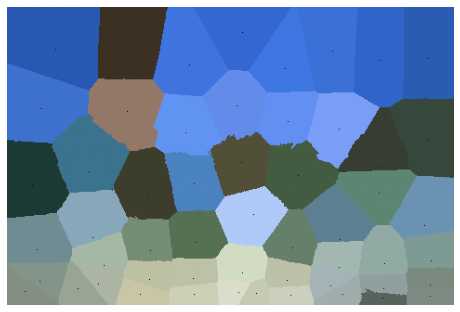

time: 12min 22s (started: 2022-11-26 02:33:03 +00:00)


In [13]:
clusters,image = slicPipeline(img_path0,64,1,10)
display_clusters(image,clusters)


 **average size S: 49

iteration: 0

iteration: 1

iteration: 2

iteration: 3

iteration: 4

iteration: 5**



**3.1.1 Part2 : only spatial distance**

**3.2 for m1 = 0 and m2 = 10**


iteration: 0
res_err 2335.6783476153514
iteration: 1
res_err 1709.7834358949963
iteration: 2
res_err 1023.7283129624748
iteration: 3
res_err 1213.49021447484
iteration: 4
res_err 770.1700379950496
iteration: 5
res_err 1045.0792011453477


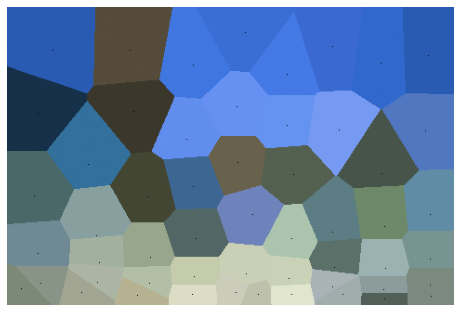

time: 15min 35s (started: 2022-11-26 02:02:15 +00:00)


In [ ]:
 ## only considering spatial distance
clusters,image = slicPipeline(img_path0,64,0,10)
display_clusters(image,clusters)

average size S: 49
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5



**3.2.1 Part3 : actual spatial and color distance (5D space)**

**4 for m1 = 1 and m2 = 1**

In [ ]:
## considering both lab and spatial distance
clusters,image = slicPipeline(img_path0,64,1,1)
display_clusters(image,clusters)


iteration: 0
res_err 2318.849194660604
iteration: 1
res_err 1513.1431665064329
iteration: 2
res_err 1180.9070150562532
iteration: 3


average size S: 49
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5


time: 7min 4s (started: 2022-11-22 01:48:24 +00:00)
5 c) Error at Initialization and Convergence

In [ ]:
clusters,image = slicPipeline(img_path1,64,1,1)
display_clusters(image,clusters)

In [ ]:
clusters,image = slicPipeline(img_path1,64,1,1)
display_clusters(image,clusters)

time: 6.24 s (started: 2022-11-26 01:26:14 +00:00)


iteration: 0

res_err 1210.1410496005794

iteration: 1

res_err 1107.6088007600085

iteration: 2

res_err 833.7255206892844

iteration: 3

res_err 666.5247525551624

iteration: 4

res_err 636.7530870561578

iteration: 5

res_err 627.5642723970115


time: 7.72 s (started: 2022-11-26 01:26:14 +00:00)




**6 d) Different no of SuperPixels**

**K=64**

iteration: 0
res_err 2355.391732709072
iteration: 1
res_err 1717.895592303964
iteration: 2
res_err 1491.2305996056157
iteration: 3
res_err 1263.6974965015174
iteration: 4
res_err 1095.7709180724141
iteration: 5
res_err 1098.865100376903


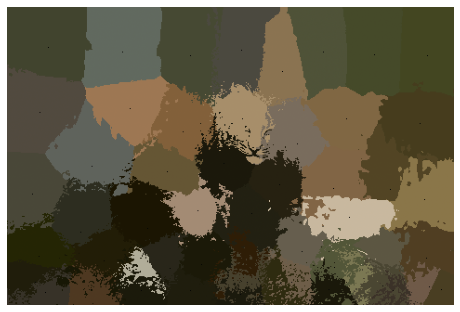

time: 12min 31s (started: 2022-11-26 03:12:54 +00:00)


In [16]:
clusters,image = slicPipeline("/content/Part1_SLIC/BSD_data/images/41085.jpg",64,1,1)
display_clusters(image,clusters)

average size S: 49
iteration: 0
res_err 1010.102889584844
iteration: 1
res_err 959.1577264140919
iteration: 2
res_err 808.6865810312818
iteration: 3
res_err 760.4676107123539
iteration: 4
res_err 649.2888482819236
iteration: 5
res_err 706.5547057753771

time: 12.2 s (started: 2022-11-26 01:27:05 +00:00)


time: 5min 46s (started: 2022-11-21 23:19:49 +00:00)
K = 256

iteration: 0
res_err 5741.4987459150425
iteration: 1
res_err 4434.292691052503
iteration: 2
res_err 4214.3695761926865
iteration: 3
res_err 4423.82694278815
iteration: 4
res_err 4244.551873065508
iteration: 5
res_err 4103.414523194321


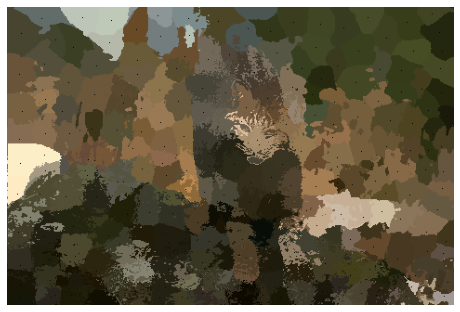

time: 59min 22s (started: 2022-11-26 03:25:56 +00:00)


In [17]:
clusters,image = slicPipeline("/content/Part1_SLIC/BSD_data/images/41085.jpg",256,1,1)
display_clusters(image,clusters)


average size S: 24

iteration: 0

res_err 3188.1160676986133

iteration: 1

res_err 2491.5153719505547

iteration: 2

res_err 2115.3754783463082

iteration: 3

res_err 1946.85589740103

iteration: 4

res_err 1921.1794763019363

iteration: 5

res_err 2222.553496527986

In [ ]:
clusters,image = slicPipeline("/content/Part1_SLIC/BSD_data/images/41085.jpg",1024,1,1)
display_clusters(image,clusters)


iteration: 0


average size S: 12

iteration: 0

iteration: 1

iteration: 2

iteration: 3

iteration: 4




**7 e) Run time:**

Average run time for K=64

iteration: 0
res_err 2318.849194660604
iteration: 1
res_err 1513.1431665064329
iteration: 2
res_err 1180.9070150562532
iteration: 3
res_err 1094.5237397237947
iteration: 4
res_err 932.233464858874
iteration: 5
res_err 911.7398697420897


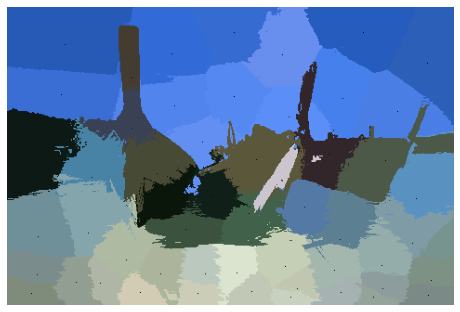

iteration: 0
res_err 2398.170385252822
iteration: 1
res_err 1508.3590038081443
iteration: 2
res_err 1260.9449326337412
iteration: 3
res_err 1061.3376348611496
iteration: 4
res_err 1060.7573176553915
iteration: 5
res_err 969.477930533378


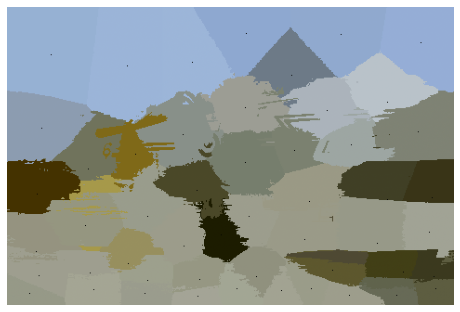

iteration: 0
res_err 3142.9978014371004
iteration: 1
res_err 2409.25643181015
iteration: 2
res_err 1968.532452844027
iteration: 3
res_err 1976.5833323340105
iteration: 4
res_err 2004.964390681464
iteration: 5
res_err 1499.0682917048434


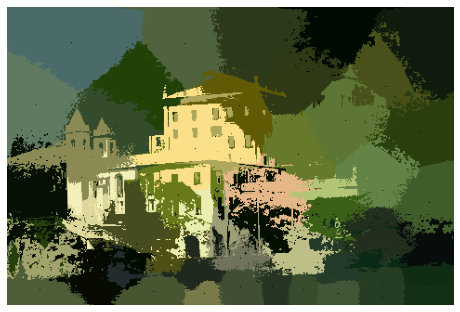

iteration: 0
res_err 2395.9928756903473
iteration: 1
res_err 1929.1199650056951
iteration: 2
res_err 1550.415212707247
iteration: 3
res_err 1334.9509511985636
iteration: 4
res_err 1034.3285047935951
iteration: 5
res_err 969.113805486027


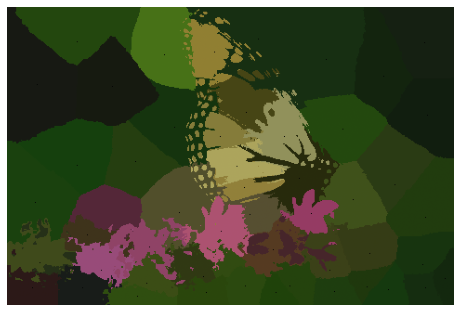

iteration: 0
res_err 2355.391732709072
iteration: 1
res_err 1717.895592303964
iteration: 2
res_err 1491.2305996056157
iteration: 3
res_err 1263.6974965015174
iteration: 4
res_err 1095.7709180724141
iteration: 5
res_err 1098.865100376903


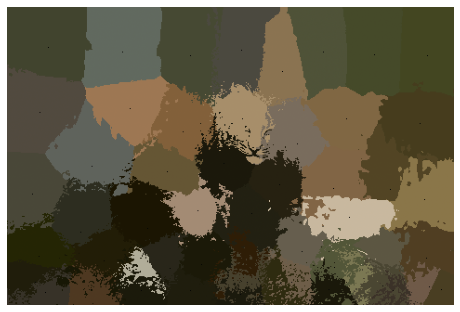

time: 1h 5min 30s (started: 2022-11-26 05:55:08 +00:00)


In [9]:
t1 = time.perf_counter()
paths=[img_path0,img_path1,img_path2,img_path3,img_path4]
for path_ in paths:
  clusters,image = slicPipeline(path_,64,1,1)
  display_clusters(image,clusters)
t2 = time.perf_counter()




Average run time per image for K=64: -437.02177176460026

time: 36min 25s (started: 2022-11-22 05:51:46 +00:00)

In [10]:
t = 36/5
print(f"Average run time for K= 64 is {t} minutes")

Average run time for K= 64 is 7.2 minutes
time: 888 µs (started: 2022-11-26 07:00:48 +00:00)


Average run time for K= 64 is 7.2 minutes

time: 1.08 ms (started: 2022-11-22 13:39:31 +00:00)

Average run time for K=256

iteration: 0
res_err 5076.911770069713
iteration: 1
res_err 4071.8521591779413
iteration: 2
res_err 3655.0445740441296
iteration: 3
res_err 3979.1806703086168
iteration: 4
res_err 3375.0414055569845
iteration: 5
res_err 3377.845865889422


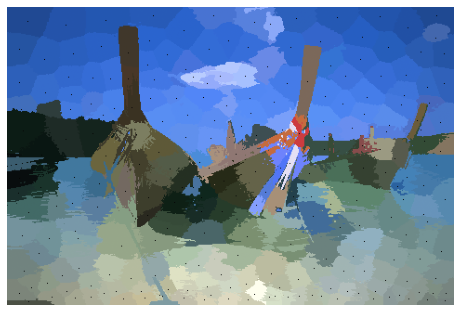

iteration: 0
res_err 4998.194627764699
iteration: 1
res_err 3618.3230714042816
iteration: 2
res_err 3353.999533116397
iteration: 3
res_err 3468.844618424665
iteration: 4
res_err 3540.0579791254445
iteration: 5


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


res_err 2773.051940358164


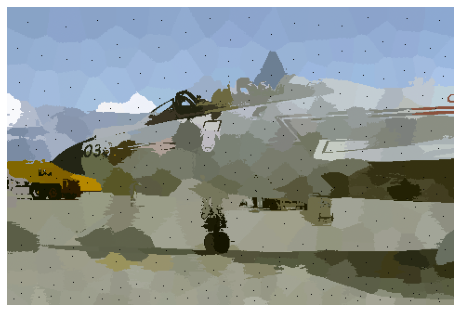

iteration: 0
res_err 9019.42128588752
iteration: 1
res_err 7887.5276436604145
iteration: 2
res_err 7621.3686639232565
iteration: 3
res_err 7459.703665006005
iteration: 4
res_err 6748.874516119127
iteration: 5
res_err 6672.151878850274


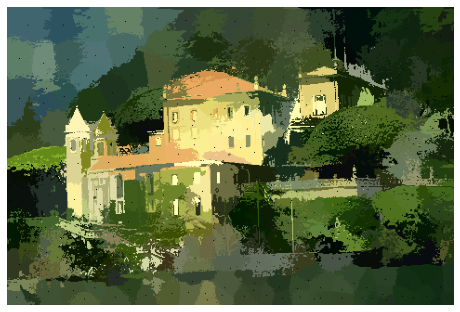

iteration: 0
res_err 5234.158036244484
iteration: 1
res_err 4170.668667602389
iteration: 2
res_err 3759.4060107211935
iteration: 3
res_err 3803.59702896716
iteration: 4
res_err 3703.959607742848
iteration: 5
res_err 3818.3283098047705


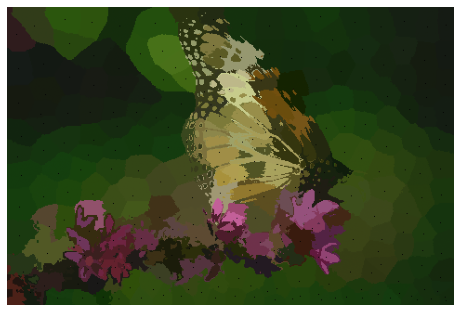

iteration: 0
res_err 5741.4987459150425
iteration: 1
res_err 4434.292691052503
iteration: 2
res_err 4214.3695761926865
iteration: 3
res_err 4423.82694278815
iteration: 4
res_err 4244.551873065508
iteration: 5
res_err 4103.414523194321


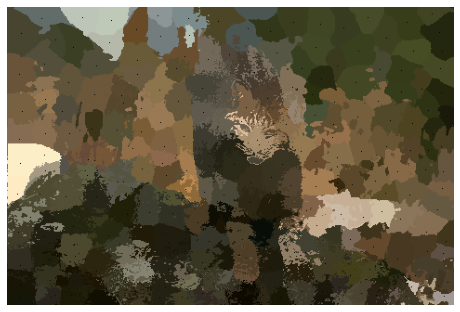

time: 5h 15min 31s (started: 2022-11-26 07:00:52 +00:00)


In [11]:
paths=[img_path0,img_path1,img_path2,img_path3,img_path4]
for path_ in paths:
  clusters,image = slicPipeline(path_,256,1,1)
  display_clusters(image,clusters)


time: 2h 41min 6s (started: 2022-11-22 14:39:52 +00:00)

In [ ]:
print(f"Average run time for k=256 is: {161/5} minutes")

Average run time for k=256 is: 32.2 minutes
time: 795 µs (started: 2022-11-25 17:42:57 +00:00)


In [ ]:
paths=[img_path0,img_path1,img_path2,img_path3,img_path4]
for path_ in paths:
  clusters,image = slicPipeline(path_,1024,1,1)
  display_clusters(image,clusters)


iteration: 0


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441:

RuntimeWarning: Mean of empty slice.
out=out, **kwargs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182:

RuntimeWarning: invalid value encountered in true_divide

ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
print("Average run time for K = 1024 is: 1hr 51 minutes ")

Average run time for K = 1024 is: 1hr 51 minutes 
time: 2.03 ms (started: 2022-11-25 17:44:39 +00:00)


Average run time for K = 1024 is: 1hr 51 minutes

**7.0.1 Hints**

• For main part, you CAN NOT use any library such as skimage / cv2 to perform or implement SLIC segmentation.

• For better visualization, you may use external function (skimage.segmentation.mark_boundaries) for your purpose.

• For EXTRA CREDIT part, you are allowed to use external library for metrics (boundary recall and under-segmentation error)

**8 Part 2:** **Graph-cut Segmentation (50 points)**

**8.1 Overview**

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given
a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better
segmentation!
Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of
Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the providedbounding-boxes and use “cv2 package” for the implementation sake. You are required to drawinteresting conclusions on how it performs on different samples.

**8.2 Data**

In [16]:
 # Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 107MB/s]
Archive:  /content/Part2_GraphCut.zip
replace /content/Part2_GraphCut/dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOS

**8.3 Helper Functions**
**Code (15 pts)**

In [17]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
  fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords,vertex_col_coords, shape)
  mask = np.zeros(shape, dtype=np.uint8)
  mask[fill_row_coords, fill_col_coords] = 1
  return mask
# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


time: 1.39 ms (started: 2022-11-26 19:28:41 +00:00)


time: 7.22 ms (started: 2022-11-23 20:40:31 +00:00)

In [37]:
def mask_for_fg(img, img_mask):
# to generate foreground region (and everything else masked out).
  fg_image = np.multiply(img,img_mask[:,:,np.newaxis])
  return fg_image
def mask_for_bg(img, img_mask):
# Write code here
# generate background region (and everything else masked out).
  bg_image = np.multiply(img,1-img_mask[:,:,np.newaxis])
  return bg_image
def gaussian_model(img):
# Write your code here.
# fit gaussian model on a given image.
  dataPoints = np.reshape(img,(-1,3))
  gmm_model = GaussianMixture(n_components=2,random_state=0).fit(dataPoints)
  gmm_labels = gmm_model.predict(dataPoints)
  return gmm_model, gmm_labels
def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  dataPoints = np.reshape(img,[-1,3])
# calculate fg likelihood
  fg_likelihood= gmm_fg.score_samples(dataPoints)
  likelihood_map_fg = -1* np.reshape(fg_likelihood,(img.shape[0],img.shape[1]))
# calculate bg likelihood
  bg_likelihood= gmm_bg.score_samples(dataPoints)
  likelihood_map_bg = -1* np.reshape(bg_likelihood,(img.shape[0],img.shape[1]))
  show_image(likelihood_map_bg,2.0)
  show_image(likelihood_map_fg,2.0)
  return None
def run_grabcut(image,img_name, bboxes,iter):
# Write your code here.
# You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to␣implement this.
  grabcut_mask = np.zeros(image.shape[:2],np.uint8)
  bgModel, fgModel = np.zeros((1,65),np.float64), np.zeros((1,65),np.float64)
  bbox = bboxes[img_name]
# cv2 grabcut
  grabcut_mask, bgModel , fgModel = cv2.grabCut(image,grabcut_mask,bbox,bgModel,fgModel,iter,cv2.GC_INIT_WITH_RECT)
  grabcut_mask = np.where((grabcut_mask == 2)|(grabcut_mask == 0), 0, 1).astype('uint8')
  return (grabcut_mask, bgModel, fgModel,image)
def run_grabcut2(image, custom_mask):
  bgModel, fgModel = np.zeros((1,65),np.float64), np.zeros((1,65),np.float64)
# cv2 grabcut
  grabcut_mask, bgModel , fgModel = cv2.grabCut(image,custom_mask,None,bgModel,fgModel,5,cv2.GC_INIT_WITH_MASK)
  grabcut_mask = np.where((grabcut_mask == 2)|(grabcut_mask == 0), 0, 1).astype('uint8')
  return (grabcut_mask, bgModel, fgModel,image)
def readImage(name):
# read image
  img_path = '/content/Part2_GraphCut/'+ name + '.jpg'
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  return img
def getMaskfromCord(img,poly):
  mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))
  return mask

time: 5.56 ms (started: 2022-11-26 20:24:19 +00:00)


In [38]:
from matplotlib.transforms import BlendedGenericTransform
### Main Block: ###
catImage = readImage('cat')
dogImage = readImage('dog')
planeImage= readImage('plane')
messiIMage= readImage('messi')
birdImage= readImage('bird')
# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
cat_poly=np.array([[37,361],[58,388],[75,395],[199,377],[261,374],[315,360],
                   [306,340],[330,248],[323,204],[319,176],[299,149],[252,95],
                   [238,90],[223,79],[217,85],[203,97],[193,125],[191,145],
                   [185,160],[197,176],[217,177],[232,178],[230,211],[208,243],
                   [176,300],[16169,338]])
dog_poly=np.array([[353,45],[345,265],[363,536],[360,614],[395,665],[518,622],
                   [586,499],[657,384],[613,321],[597,300],[524,269],[499,192],
                   [433,154],[373,52]])
bird_poly=np.array([[258,93],[199,124],[113,289],[105,333],[52,380],[56,399],
                    [63,403],[78,395],[81,394],[108,396],[130,383],[140,365],
                    [145,347],[157,345],[181,365],[206,376],[215,420],[218,454],
                    [255,479],[270,464],[266,403],[228,403],[226,367]])

time: 37.2 ms (started: 2022-11-26 20:24:20 +00:00)


In [39]:
 # 1. Fit Gaussian mixture model for foreground regions.
img_mask= getMaskfromCord(catImage,cat_poly)
# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(catImage, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)
# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(catImage, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)

time: 3.6 s (started: 2022-11-26 20:24:21 +00:00)


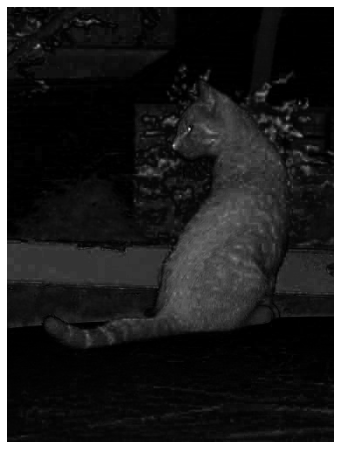

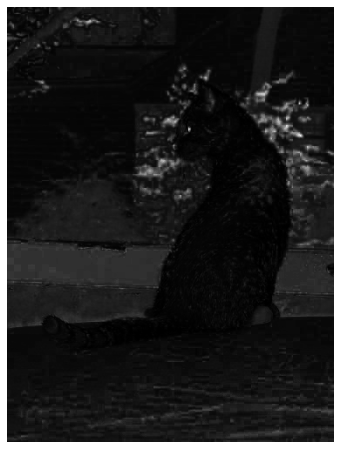

time: 411 ms (started: 2022-11-26 20:24:25 +00:00)


In [40]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]
visualize_likelihood_map(gmm_bg, gmm_fg, catImage)


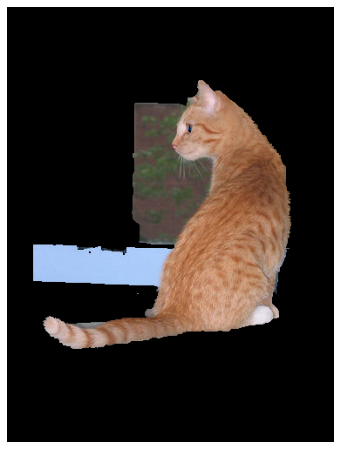

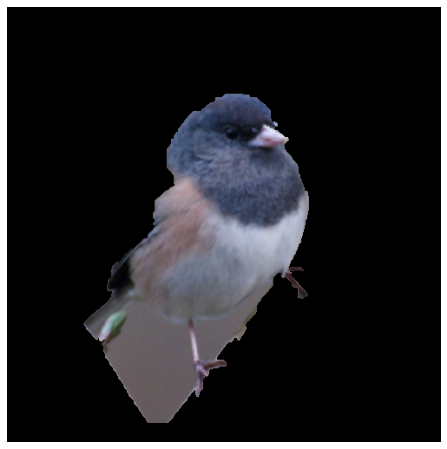

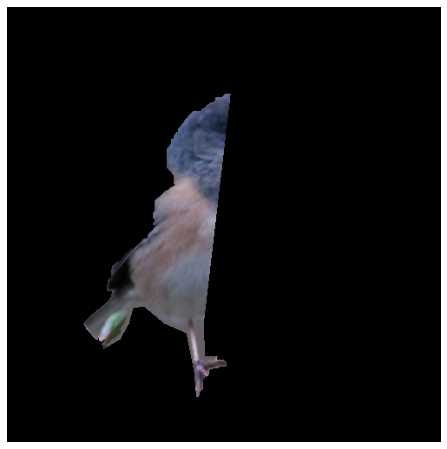

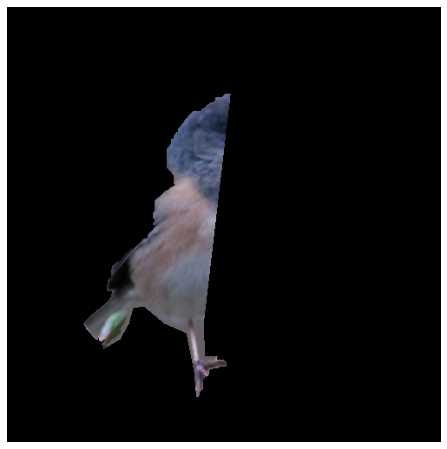

time: 13.6 s (started: 2022-11-26 20:24:27 +00:00)


In [41]:
 # 4. Run grabcut algorithm.
bboxes = {'cat':(30,80,320,320), 'dog':(312,45,335,615), 'plane':(38,188,840,245), 'messi':(74,5,587,444), 'bird':(58,95,296,385)}
for img_string in bboxes:
# get image
  img_path = '/content/Part2_GraphCut/'+ img_string + '.jpg'
  image = cv2.imread(img_path)
  if img_string in ['cat','bird']:
    (grabcut_mask, bgModel, fgModel,img) = run_grabcut(image,img_string,bboxes,5)
# image after 1st grab cut
    masked_img = img*grabcut_mask[:,:,np.newaxis]
    show_image(masked_img[:,:,::-1],2)
# optimizing cut with 2nd grabcut
    if img_string== 'cat':
      mask2 = getMaskfromCord(image,cat_poly)
    else:
      mask2 = getMaskfromCord(image,bird_poly)
## perform grabcut for 2nd time
      (grabcut_mask, bgModel, fgModel,img) = run_grabcut2(masked_img,mask2)
      masked_img = img*grabcut_mask[:,:,np.newaxis]
      show_image(masked_img[:,:,::-1],2)
  else:
    (grabcut_mask, bgModel, fgModel,img) = run_grabcut(image,img_string,bboxes,5)
# image after 1st grab cut
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img[:,:,::-1],2)

time: 16.5 s (started: 2022-11-24 02:07:21 +00:00)
8.3.1 Write-up (35 points)
• a) [5 points] Explain your foreground and background likelihood function.
• b) [10 points] Your foreground and background likelihood map.
Display P(foreground|pixel) as an intensity map (bright = confident foreground). - c) [15 points]
Implement grabcut segmentation using cv2 package and draw insights on how the segmentation
performs on different sample images (hard v/s easy). - d) [5 points] Try grabcut algorithm with
different “iterCount” to see if results improve in certain cases.

8.4 a) foreground and background likelihood
Given a fg_model and bg_model , GMM score() method is used to predict whether each pixel is
either a fg or bg.The probability that pixel is a fg or bg is calculated and plotted using visualize_likelihood() function.
8.5 b) Likelihood map

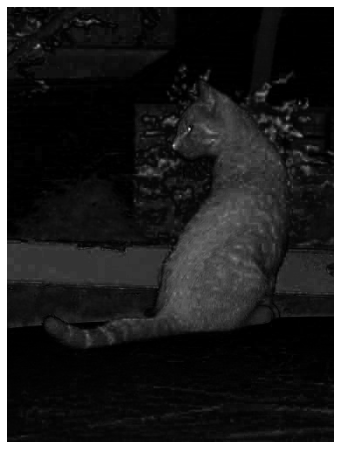

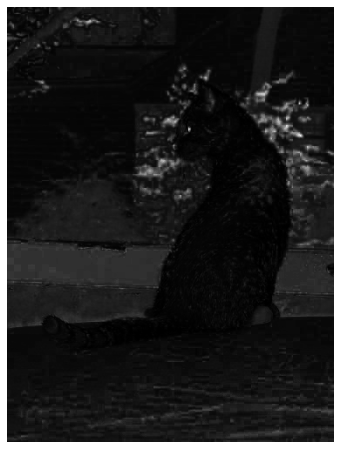

time: 419 ms (started: 2022-11-26 20:24:53 +00:00)


In [42]:
visualize_likelihood_map(gmm_bg, gmm_fg, catImage)

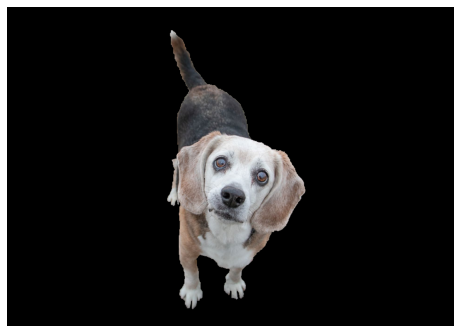

time: 2.42 s (started: 2022-11-26 20:25:00 +00:00)


In [43]:
(grabcut_mask, bgModel, fgModel,img) = run_grabcut(dogImage,'dog', bboxes,5)
# image after 1st grab cut
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img,2)

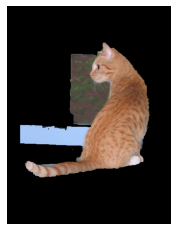

time: 1.3 s (started: 2022-11-26 20:26:34 +00:00)


In [45]:
#Iteration = 5
(grabcut_mask, bgModel, fgModel,img) = run_grabcut(catImage,'cat', bboxes,5)
# image after 1st grab cut
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img,1)


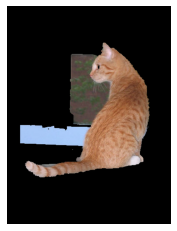

time: 4.66 s (started: 2022-11-26 20:27:04 +00:00)


In [46]:
#Iteration = 25
(grabcut_mask, bgModel, fgModel,img) = run_grabcut(catImage,'cat', bboxes,25)
# image after 1st grab cut
masked_img = img*grabcut_mask[:,:,np.newaxis]
show_image(masked_img,1)